In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import random
import warnings
import time
import math

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False
# 한글 폰트 설정
plt.rcParams['font.family'] = "NanumGothic"

warnings.filterwarnings('ignore')

data_dir = 'data'

df = pd.read_csv("./new_df.csv")
df

,value,label
0,반려동물의 종류에 대해서 알고 계신가요,네
1,키우는 반려동물이 있으신가요,네
2,연예인들의 이색 반려견에 대해서 어떻게 아시나요,연예인의 이색 반려 동물에 대해서 저의 제 개인적인 생각은 연예인들이 반려동물을 이...
3,반려동물과의 추억은 어떤 것을 가지고 있으신가요,저는 지금 현재 고양이 세 마리와 강아지 한 마리를 를 키우고 있는데 한 마리 마리...
4,반려동물을 키우기 위한 조건 세 가지가 있다면 어떤 것이 있다고 생각합니까,제가 생각하는 반려동물 키우기 위한 필요한 세 가지는 일단 반려동물을 사랑하는 마음...
...,...,...
25325,다른 과랑 모여서 듣는 교양 수업도 있다고 하셨는데 그렇게 된다면 여러 과 학생이 ...,그거는 교과목에 따라 다른 편인데 교과목에 따라 정원이 정해져 있어요
25326,고등학교 시험은 단순히 시험지를 푸는 것에 그치지만 대학교 시험은 서술형으로 자신의...,보통 중간고사 기말고사가 있고 보 그거는 교수님의 자유로 진행이 돼요
25327,또 고등학교와 대학교의 다른 점이 고등학교에서는 선생님 이라고 부르고 대학교에는 교...,정말 다양한 교수님이 있는데요
25328,어~ 그런 선배들이랑은 오티나 엠티 아니면 술자리에서 친해진다고 들었는데 그렇게 해...,저희 과는 술자리가 굉장히 많은 편이었어요


In [2]:
question = df['value']
answer = df['label']

데이터 전처리

In [3]:
#한글 정규화
import re

# 한글, 영어, 숫자, 공백, ?!.,을 제외한 나머지 문자 제거
korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'

# 패턴 컴파일
normalizer = re.compile(korean_pattern)
normalizer

re.compile(r'[^ ?,.!A-Za-z0-9가-힣+]', re.UNICODE)

In [4]:
def normalize(sentence):
    return normalizer.sub("", sentence)

normalize(question[10])

'안녕하세요'

In [5]:
from konlpy.tag import Okt

# 형태소 분석기

okt = Okt()

In [6]:
# okt
okt.morphs(normalize(answer[10]))

['반갑습니다']

In [7]:
# 한글 전처리를 함수화
def clean_text(sentence, tagger):
    sentence = normalize(sentence)
    sentence = tagger.morphs(sentence)
    sentence = ' '.join(sentence)
    sentence = sentence.lower()
    return sentence

In [8]:
clean_text(question[10], okt)

'안녕하세요'

In [9]:
clean_text(answer[10], okt)

'반갑습니다'

In [10]:
len(question), len(answer)

(25330, 25330)

In [11]:
questions = [clean_text(str(sent), okt) for sent in question.values]
answers = [clean_text(str(sent), okt) for sent in answer.values]

In [12]:
len(questions), len(answers)

(25330, 25330)

In [13]:
max = 0

for i in range(len(questions)):
    if max < len(questions[i].split()):
        max = len(questions[i].split())
        
for i in range(len(answers)):
    if max < len(answers[i].split()):
        max = len(answers[i].split())
        
max

358

In [14]:
#단어 사전 생성
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [15]:
class WordVocab():
    def __init__(self):
        SOS_TOKEN = 0
        EOS_TOKEN = 1
        UNKNOWN_TOKEN = 2
        
        self.unknown_token = UNKNOWN_TOKEN
        
        # 각 토큰 별 word count
        self.word2count = {}
        
        # word -> idx
        self.word2index = {
            '<SOS>': SOS_TOKEN, 
            '<EOS>': EOS_TOKEN,
            '<UKN>': UNKNOWN_TOKEN,
        }

        # idx -> word
        self.index2word = {
            SOS_TOKEN: '<SOS>', 
            EOS_TOKEN: '<EOS>', 
            UNKNOWN_TOKEN: '<UKN>',
        }
        
        # total word counts
        self.n_words = 3  # SOS, EOS, UNKNOWN 포함

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def word_to_index(self, word):
        if word in self.word2index:
            return self.word2index[word]
        else:
            return self.unknown_token
    
    def index_to_word(self, idx):
        return self.index2word[idx]

In [16]:
print(f'원문: {questions[10]}')
wordvocab = WordVocab()
wordvocab.add_sentence(questions[10])
print('==='*10)
print('단어사전')
print(wordvocab.word2index)

원문: 안녕하세요
단어사전
{'<SOS>': 0, '<EOS>': 1, '<UKN>': 2, '안녕하세요': 3}


In [72]:
#전처리 프로세스를 클레스화 - 데이터 로드, 전처리, 사전 생성, 시퀀스 변환
from konlpy.tag import Okt


class QADataset():
    def __init__(self, csv_path, min_length=1, max_length=647):
        data_dir = 'data'
        
        # TOKEN 정의
        self.SOS_TOKEN = 0 # SOS 토큰
        self.EOS_TOKEN = 1 # EOS 토큰
        
        self.tagger = Okt()   # 형태소 분석기
        self.max_length = max_length # 한 문장의 최대 길이 지정
        
        # CSV 데이터 로드
        df = pd.read_csv(csv_path)
        
        # 한글 정규화
        korean_pattern = r'[^ ?,.!A-Za-z0-9가-힣+]'
        self.normalizer = re.compile(korean_pattern)
        
        # src: 질의, tgt: 답변
        src_clean = []
        tgt_clean = []
        
        # 단어 사전 생성
        wordvocab = WordVocab()
        
        for _, row in df.iterrows():
            src = row['value']
            tgt = row['label']
            
            # 한글 전처리
            src = self.clean_text(src)
            tgt = self.clean_text(tgt)
            
            if len(src.split()) > min_length and len(tgt.split()) > min_length:
                # 최소 길이를 넘어가는 문장의 단어만 추가
                wordvocab.add_sentence(src)
                wordvocab.add_sentence(tgt)
                src_clean.append(src)
                tgt_clean.append(tgt)            
        
        self.srcs = src_clean
        self.tgts = tgt_clean
        self.wordvocab = wordvocab
        

    
    def normalize(self, sentence):
        # 정규표현식에 따른 한글 정규화
        return self.normalizer.sub("", sentence)

    def clean_text(self, sentence):
        # 한글 정규화
        sentence = self.normalize(str(sentence))
        # 형태소 처리
        sentence = self.tagger.morphs(sentence)
        sentence = ' '.join(sentence)
        sentence = sentence.lower()
        return sentence
    
    def texts_to_sequences(self, sentence):
        # 문장 -> 시퀀스로 변환
        sequences = [self.wordvocab.word_to_index(w) for w in sentence.split()]
        # 문장 최대 길이 -1 까지 슬라이싱
        sequences = sequences[:self.max_length-1]
        # 맨 마지막에 EOS TOKEN 추가
        sequences.append(self.EOS_TOKEN)
        return sequences
    
    def sequences_to_texts(self, sequences):
        # 시퀀스 -> 문장으로 변환
        sentences = [self.wordvocab.index_to_word(s.item()) for s in sequences]
        return ' '.join(sentences)

    
    def __getitem__(self, idx):
        inputs = self.srcs[idx]
        inputs_sequences = self.texts_to_sequences(inputs)
        
        outputs = self.tgts[idx]
        outputs_sequences = self.texts_to_sequences(outputs)
        
        return torch.tensor(inputs_sequences).view(-1, 1), torch.tensor(outputs_sequences).view(-1, 1)
    
    def __len__(self):
        return len(self.srcs)

In [71]:
MAX_LENGTH = 358

dataset = QADataset('./new_df.csv', min_length=1, max_length=MAX_LENGTH)

In [19]:
x, y = dataset[3]

# 시퀀스를 문장으로 변환
print(dataset.sequences_to_texts(x))
print(dataset.sequences_to_texts(y))

반려동물 용품 의 매출 이 높아지기 위 해서는 어떻게 해야 된다고 생각 합 니까 <EOS>
반려동물 용품 매출 이 높아지기 위 해서는 일단 자신 이 데리 고 있는 반려동물 이 더 응 반려동물 에 대해 더 애정 을 주고 그리고 반려 동 반려동물 용품 을 을 팔고 있으신 분 들 이 그만큼 반려동물 의 매력 을 더 사람 들 이 알 알 게 해주기 위해 에스 엔 에스 혹은 블로그 같은 그런 것 도 이용 을 하 이용 을 하면서 반려동물 용품 매출 이 상승 할 거 같습니다 <EOS>


Encoder

In [59]:
class Encoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, num_layers):
        super(Encoder, self).__init__()
        
        # 단어 사전의 개수 지정
        self.num_vocabs = num_vocabs
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        
        # 임베딩 레이어 정의 (number of vocabs, embedding dimension)
        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        # GRU (embedding dimension)
        self.gru = nn.GRU(embedding_dim, 
                          hidden_size, 
                          num_layers=num_layers, 
                          bidirectional=False, 
                          batch_first=True,
                         )
    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.gru.weight.data)
        
    def forward(self, x, hidden):
        # (sequence_length, 1)
        x = self.embedding(x).view(1, 1, -1)
        # x: (1, 1, embedding_dim)
        # hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        output, hidden = self.gru(x, hidden)
        # output: (batch_size, sequence_length, hidden_size(32) x bidirectional(1))
        # hidden: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        return output, hidden
    
    def init_hidden(self, device):
        # hidden_state: (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32)) 로 초기화
        return torch.zeros(1, 1, self.hidden_size, device=device)

attention이 적용된 Decoder

In [60]:
class AttentionDecoder(nn.Module):
    def __init__(self, num_vocabs, hidden_size, embedding_dim, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttentionDecoder, self).__init__()
        self.hidden_size = hidden_size
        self.max_length = max_length

        self.embedding = nn.Embedding(num_vocabs, embedding_dim)
        self.attn = nn.Linear(hidden_size + embedding_dim , max_length)
        self.attn_combine = nn.Linear(hidden_size + embedding_dim, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, num_vocabs)
    
    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.gru.weight.data)
    
    def forward(self, x, hidden, encoder_outputs):
        # x: (1, 1) 1개의 토큰
        embedded = self.embedding(x).view(1, 1, -1)
        # embedded: (1, 1, 1)
        embedded = self.dropout(embedded)

        
        # embedded[0]: (1, embedding_dim)
        # hidden[0]: (1, hidden_size)
        attn_in = torch.cat((embedded[0], hidden[0]), 1)
        # attn_in: (1, embedding_dim + hidden_size)
                            
        attn = self.attn(attn_in)
        # attn: (1, max_length)
                         
        attn_weights = F.softmax(attn)
        # attn_weights: (1, max_length)
        
        # (1, 1, max_length), (1, max_length, hidden_size)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        # attn_applied: (1, 1, hidden_size)

        # embedded[0]: (1, embedding_dim)
        # attn_applied[0]: (1, hidden_size)
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        # output: (1, embedding_dim + hidden_size)
        
        output = self.attn_combine(output)
        # output: (1, hidden_size)
        output = output.unsqueeze(0)
        # output: (1, 1, hidden_size)

        output = F.relu(output)
        # output: (1, 1, hidden_size)
        
        # output: (1, 1, hidden_size)
        # hidden: (1, 1, hidden_size)
        output, hidden = self.gru(output, hidden)
        # output: (1, 1, hidden_size)
        # hidden: (1, 1, hidden_size)
        
        # output[0]: (1, hidden_size)
        output = self.out(output[0])
        # output: (1, number of vocabs)
        
        # output[0]: (number of vocabs)
        # hidden: (1, 1, hidden_size)
        # attn_weights: (1, max_length)
        return output[0], hidden, attn_weights

    def initHidden(self, device):
        # (Bidirectional(1) x number of layers(1), batch_size, hidden_size(32))
        return torch.zeros(1, 1, self.hidden_size, device=device)

Training

In [61]:
SOS_TOKEN = dataset.SOS_TOKEN
EOS_TOKEN = dataset.EOS_TOKEN

In [62]:
# 훈련시 training loss 를 출력하기 위한 util 함수
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # 주기적인 간격에 이 locator가 tick을 설정
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.title('Losses over training')
    plt.show()
    
# 훈련시 시간 출력을 위한 util 함수
def as_minutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return f'{int(m)}m {int(s)}s'

# 훈련시 시간 출력을 위한 util 함수
def time_since(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return f'{as_minutes(s)} (remaining: {as_minutes(rs)})'

In [63]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
          decoder_optimizer, criterion, device, max_length=MAX_LENGTH, teacher_forcing_ratio=0.5):
    
    # Encoder의 hidden_state 초기화
    encoder_hidden = encoder.init_hidden(device=device)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # input_length: 입력 문장의 길이
    # target_length: 출력 문장의 길이
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # Encoder의 출력 결과를 담을 tensor
    # (문장의 max_length, encoder의 hidden_size)
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        # Encoder의 출력을 encoder_outputs[ei] 에 저장
        # encoder_output[0, 0]: (hidden_size,)
        encoder_outputs[ei] = encoder_output[0, 0]

    # Decoder의 첫 토큰은 SOS_TOKEN
    decoder_input = torch.tensor([[SOS_TOKEN]], device=device)

    # Encoder의 마지막 hidden state를 Decoder의 초기 hidden state로 지정
    decoder_hidden = encoder_hidden

    # teacher forcing 적용 여부 확률로 결정
    # teacher forcing 이란: 정답치를 다음 RNN Cell의 입력으로 넣어주는 경우. 수렴속도가 빠를 수 있으나, 불안정할 수 있음
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)

        # loss 계산
        loss += criterion(decoder_output.view(1, -1), target_tensor[di])

        if use_teacher_forcing:
            # teacher forcing 적용: 정답 값 입력
            decoder_input = target_tensor[di]
        else:
            # 확률, 인덱스
            topv, topi = decoder_output.topk(1)
            # 다음 입력으로 주입할 디코더 최종 토큰 결정
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

        # EOS_TOKEN 이면 종료
        if decoder_input.item() == EOS_TOKEN:
            break

    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [64]:
def train_iterations(encoder, decoder, n_iters, dataset, device, print_every=1000, plot_every=100, learning_rate=0.001):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0  # plot_every 마다 초기화

    encoder_optimizer = optim.AdamW(encoder.parameters(), lr=learning_rate, betas=(0.9,0.98))
    decoder_optimizer = optim.AdamW(decoder.parameters(), lr=learning_rate, betas=(0.9,0.98))
    
    encoder_scheduler = optim.lr_scheduler.StepLR(optimizer=encoder_optimizer,
                                                step_size=5.0,
                                                gamma=0.95,
                                                verbose=False)
    decoder_scheduler = optim.lr_scheduler.StepLR(optimizer=decoder_optimizer,
                                                 step_size=5.0,
                                                 gamma=0.95,
                                                 verbose=False)
    
    # 랜덤 샘플링된 데이터셋 생성
    training_pairs = [dataset[random.randint(0, len(dataset)-1)] for i in range(n_iters)]
    
    # Loss Function 정의
    criterion = nn.CrossEntropyLoss()

    # n_iters 만큼 training 시작
    for iter in range(1, n_iters + 1):
        # 문장 pair
        training_pair = training_pairs[iter - 1]        
        # 입력 문장
        input_tensor = training_pair[0]
        # 출력 문장
        target_tensor = training_pair[1]
        
        input_tensor = input_tensor.to(device)
        target_tensor = target_tensor.to(device)

        # 훈련
        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, 
                     decoder_optimizer, criterion, device)
        encoder_scheduler.step()
        decoder_scheduler.step()
        
        print_loss_total += loss
        plot_loss_total += loss

        # print_every 마다 loss 출력, 모델 저장
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f'{time_since(start, iter/n_iters)} iter: {iter} ({iter/n_iters*100:.1f}%), loss: {print_loss_avg:.4f}')
            torch.save({
                'encoder_state_dict': encoder.state_dict(),
                'decoder_state_dict': decoder.state_dict(),
                'encoder_optimizer_state_dict': encoder_optimizer.state_dict(),
                'decoder_optimizer_state_dict': decoder_optimizer.state_dict(),
                }, "./model/Text2Text-se2se.pth")

            
        # plot_every 마다 loss 시각화
        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
        

    showPlot(plot_losses)

In [67]:
# Hyper-Parameter 정의
NUM_VOCABS = dataset.wordvocab.n_words
HIDDEN_SIZE = 512
EMBEDDING_DIM = 256
DROPOUT_P = 0.3

# Encoder 정의
encoder = Encoder(NUM_VOCABS, 
                  hidden_size=HIDDEN_SIZE, 
                  embedding_dim=EMBEDDING_DIM, 
                  num_layers=1)

# Attention 이 적용된 Decoder 정의
decoder = AttentionDecoder(num_vocabs=NUM_VOCABS, 
                           hidden_size=HIDDEN_SIZE, 
                           embedding_dim=EMBEDDING_DIM, 
                           dropout_p=DROPOUT_P, 
                           max_length=MAX_LENGTH)

# encoder, decoder 생성 및 device 지정
encoder = encoder.to(device)
decoder = decoder.to(device)

0m 46s (remaining: 14m 49s) iter: 500 (5.0%), loss: 5.3390
1m 33s (remaining: 14m 2s) iter: 1000 (10.0%), loss: 5.1033
2m 18s (remaining: 13m 4s) iter: 1500 (15.0%), loss: 5.2667
3m 3s (remaining: 12m 12s) iter: 2000 (20.0%), loss: 5.2579
3m 50s (remaining: 11m 31s) iter: 2500 (25.0%), loss: 5.1905
4m 37s (remaining: 10m 48s) iter: 3000 (30.0%), loss: 5.2368
5m 27s (remaining: 10m 8s) iter: 3500 (35.0%), loss: 5.1697
6m 9s (remaining: 9m 13s) iter: 4000 (40.0%), loss: 4.9845
6m 55s (remaining: 8m 27s) iter: 4500 (45.0%), loss: 5.0628
8m 3s (remaining: 8m 3s) iter: 5000 (50.0%), loss: 4.8748
9m 11s (remaining: 7m 31s) iter: 5500 (55.0%), loss: 5.0002
10m 23s (remaining: 6m 55s) iter: 6000 (60.0%), loss: 5.1119
11m 29s (remaining: 6m 11s) iter: 6500 (65.0%), loss: 5.1037
12m 40s (remaining: 5m 25s) iter: 7000 (70.0%), loss: 4.9730
13m 42s (remaining: 4m 34s) iter: 7500 (75.0%), loss: 5.0481
14m 55s (remaining: 3m 43s) iter: 8000 (80.0%), loss: 5.0029
16m 4s (remaining: 2m 50s) iter: 8500

<Figure size 640x480 with 0 Axes>

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

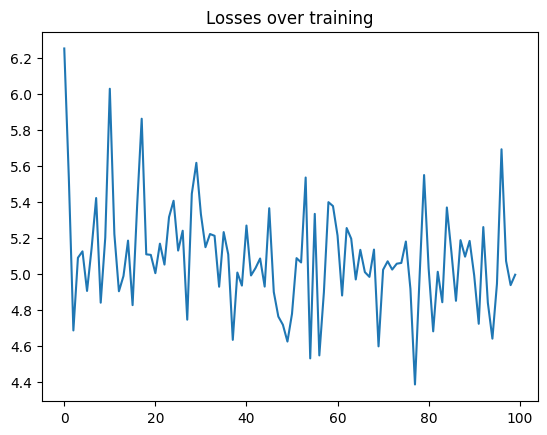

In [68]:
train_iterations(encoder, decoder, 10000, dataset, device, print_every=500)

Evaluation

In [195]:
def evaluate(encoder, decoder, input_tensor, dataset, device, max_length=MAX_LENGTH):
    # Eval 모드 설정
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        input_length = input_tensor.size(0)
        # Encoder의 hidden state 초기화
        encoder_hidden = encoder.init_hidden(device=device)

        # encoder_outputs는 Encoder를 통과한 문장의 출력
        # (max_length, hidden_size)
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # Encoder 에 입력 문자 주입 후 encoder_outputs 생성
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        # Decoder의 첫 번째 입력으로 SOS_TOKEN 입력(SOS_TOKEN=0)
        decoder_input = torch.tensor([[0]], device=device)

        # Decoder의 첫 번째 hidden state는 Encoder의 마지막 hidden state 사용
        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            # 1개의 Decoder 입력 토큰을 통과
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            
            # Attention 시각화를 위한 tensor 저장
            decoder_attentions[di] = decoder_attention.data

            # 출력 토큰 예측
            topv, topi = decoder_output.data.topk(1)

            # EOS_TOKEN이면 종료
            if topi.item() == dataset.EOS_TOKEN:
                decoded_words.append('<EOS>')
                break
            else:
                # 출력 문장에 토큰 시퀀스(index)를 단어(word)로 변환한 후 저장
                decoded_words.append(dataset.wordvocab.index_to_word(topi.item()))

            # decoder_input은 다음 토큰 예측시 입력 값
            # decoder_input: (hidden_size,)
            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]
    
    
def evaluate_randomly(encoder, decoder, dataset, device, n=10):
    for i in range(n):
        # 랜덤 샘플링
        x, y = random.choice(dataset)
        # 입력 문장, 출력 문장 (Ground Truth)
        print('>', dataset.sequences_to_texts(x))
        print('=', dataset.sequences_to_texts(y))

        # 예측
        output_words, attentions = evaluate(encoder, decoder, x.to(device), dataset, device)
        output_sentence = ' '.join(output_words)
        
        # 예측 문장 출력
        print('<', output_sentence)
        print('')

In [196]:
# 랜덤 샘플링 된 데이터 evaluate
evaluate_randomly(encoder, decoder, dataset, device)

> 그렇게 무서울 때 는 어떻게 해야 할까 요 <EOS>
= 저 같은 경우 는 학교 때 는 말씀 하신 거 처럼 진짜 막연하게 그냥 하면 되겠지 하는 생각 을 많이 했었거든요 <EOS>
< 저 는 는 에 이 가 <EOS>

> 후회 할 시간 없이 음 그럼 name 1 씨 는 앞 으로 있을 수행평가 를 어떻게 준비 하실 계획 인가요 <EOS>
= 다음 주가 수행 기간 이 잖아요 <EOS>
< 저 는 가 이 에 <EOS>

> 뭐 초등학교 때 나 중학교 때 는 좋아하던 아이돌 <EOS>
= 혹은 우상 이 곧 제 이상형 이 되곤 했었는데 현재 로써 는 그냥 저 에게 잘해주는 사람 아니면 이제 저 의 감정 을 잘 헤아려주는 사람 이 저 의 이상형 이 아닐까 합니다 <EOS>
< 저 는 가 이 가 <EOS>

> 너 는 혹시 에버랜드 나 롯데 월드 말고 다른 유원지 에를 가본 적 이 있니 <EOS>
= 정말 어릴 때 초등학교 때 는 그런 곳 을 많이 가잖아 <EOS>
< 저 는 는 가 이 에 <EOS>

> 스포츠 팀 도 적고 이 카는데 우리 애가 만약 에 스포츠 로 뭘 하려고 하면 장래 로 직업 으로 하라 하면 여보 는 어떻게 허락 할 마음 이 있나 <EOS>
= 솔직히 허락 하기는 쉽지는 않을 거 같다 <EOS>
< 저 는 가 이 가 <EOS>

> name 2 씨 는 해결 방안 에 대해 서 어떻게 생각 하세요 <EOS>
= 저 는 아까도 말 했다시피 법 으로 정해 놓는 게 제일 나은 거 같아요 <EOS>
< 저 는 는 에 이 가 <EOS>

> 음 저 는 저희 아저씨 가 그 홍삼 을 계속 해서 한 10년 째 먹고 있거든요 <EOS>
= 여 홍삼 이 사실 은 이제 삼이 다 보 니까 가격 이 인제 조 끔 부담 이 조금 되긴 해 요 <EOS>
< 저 는 가 이 에 <EOS>

> name 1 는 뭐 가 젤 기억 에 많이 남지 <EOS>
= 우리 아들 이 이 뭐 고 아들 이 나 한테 뭐 아프다고 내 가 할 수 있는 음 주중 에 할 수 있는 뭐 분리수거 <EOS>
< 저 는

attention 가중치 시각화

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

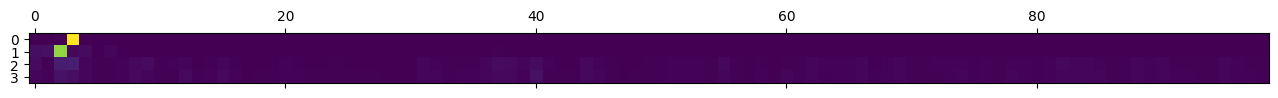

In [188]:
# Attention Weights를 활용한 시각화
output_words, attentions = evaluate(encoder, decoder, dataset[2][0].to(device), dataset, device)
plt.matshow(attentions.numpy())
plt.show()

In [189]:
# Attention 시각화를 위한 함수
def show_attention(input_sentence, output_words, attentions):
    # colorbar로 그림 설정
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # 축 설정
    ax.set_xticklabels([''] + input_sentence.split(' ') + ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # 매 틱마다 라벨 보여주기
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluate_and_show_attention(encoder, decoder, input_sentence, dataset, device):
    output_words, attentions = evaluate(encoder, decoder, input_sentence.to(device), dataset, device)
    input_sentence = dataset.sequences_to_texts(input_sentence)
    output_words = ' '.join(output_words)
    print('input =', input_sentence)
    print('output =', output_words)
    show_attention(input_sentence, output_words.split(), attentions)

In [190]:
dataset[2][0]

tensor([[23],
        [24],
        [64],
        [65],
        [54],
        [66],
        [50],
        [42],
        [67],
        [68],
        [40],
        [41],
        [22],
        [69],
        [20],
        [70],
        [71],
        [ 1]])

In [72]:
evaluate_and_show_attention(encoder, decoder, dataset[2][1], dataset, device)